In [1]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt

from statsmodels.formula.api import mixedlm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input


2025-06-18 16:10:15.863351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 16:10:15.886486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 16:10:15.893658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 16:10:15.914015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 16:10:17.113506: W tensorflow/compiler/tf2

In [ ]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_22.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

X = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

X = X.to_numpy()
X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

t_max = 20
step = 0.001

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())

original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
X.size:  (504, 68) X_resid.size:  (504, 68)
nans in cog: 0
infs in cog: 0


              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    MCATOT    
No. Observations:     504        Method:                REML      
No. Groups:           146        Scale:                 2.9357    
Min. group size:      2          Log-Likelihood:        -1119.6206
Max. group size:      4          Converged:             Yes       
Mean group size:      3.5                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              27.275    0.169 161.567 0.000 26.944 27.606
time_years             -0.123    0.066  -1.878 0.060 -0.252  0.005
Group Var               2.236    0.359                            
Group x time_years Cov  0.428    0.075                            
time_years Var          0.140    0.055                            



(array([ 1.,  1.,  1.,  3.,  5., 13., 19., 22., 39., 42.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

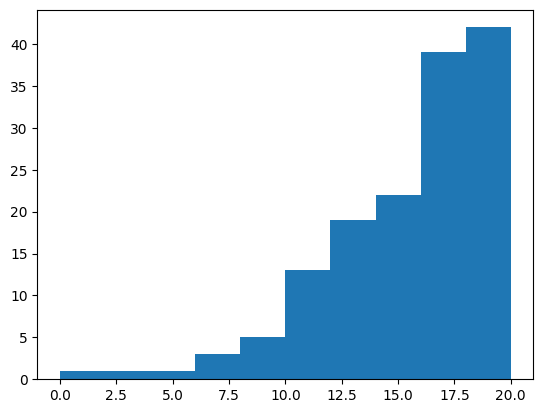

In [3]:
df_cog = df[["subj_id", "time", "MCATOT"]].copy()
df_cog["time_years"] = df_cog["time"] / 12

model = mixedlm("MCATOT ~ time_years", data=df_cog,
                groups=df_cog["subj_id"],
                re_formula="~time_years") 
result = model.fit()
print(result.summary())

random_effects = result.random_effects
id_to_slope = {pid: re["time_years"] for pid, re in random_effects.items()}
unique_ids = np.unique(df["subj_id"])
slope_array = np.array([id_to_slope.get(pid, 0.0) for pid in unique_ids])

# normalize
slope_array -= slope_array.min()
slope_array /= slope_array.max()
beta_init_reg = slope_array * t_max

plt.hist(beta_init_reg)

In [ ]:
tf.random.set_seed(10)
X_nn = df[["MCATOT", "TD_score", "PIGD_score"]].to_numpy()
y_stage = df["NHY"].to_numpy()
y_norm = (y_stage - y_stage.min()) / (y_stage.max() - y_stage.min())

model = tf.keras.Sequential([
    Input(shape=(X_nn.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # iutput is [0, 1]
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_nn, y_norm, epochs=100, batch_size=16, verbose=0)
beta_init = model.predict(X_nn) * t_max



2025-06-18 11:40:52.156626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 11:40:52.178839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 11:40:52.185594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 11:40:52.203242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 11:40:53.297461: W tensorflow/compiler/tf2

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


504


(array([119., 142., 108.,  78.,  35.,   7.,   3.,   0.,   0.,   1.,   0.,
          3.,   1.,   3.,   1.,   0.,   1.,   0.,   1.,   1.]),
 array([ 6.9763751 ,  7.56589746,  8.1554203 ,  8.74494267,  9.33446503,
         9.92398739, 10.51350975, 11.10303211, 11.69255447, 12.28207779,
        12.87160015, 13.46112251, 14.05064487, 14.64016724, 15.2296896 ,
        15.81921196, 16.40873528, 16.99825668, 17.58778   , 18.17730141,
        18.76682472]),
 <BarContainer object of 20 artists>)

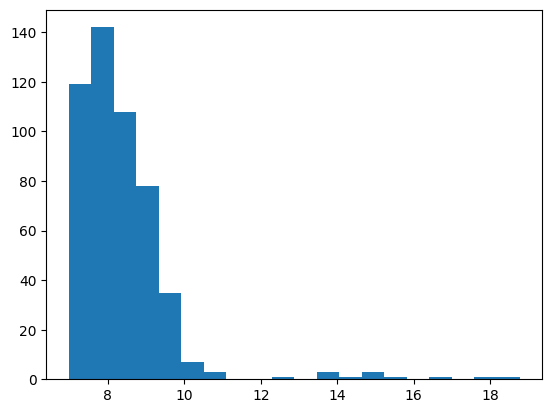

In [4]:
print(np.size(beta_init))
plt.hist(beta_init, bins=20)

In [ ]:
initial_beta = np.zeros_like(np.unique(ids))

for idx, pid in enumerate(np.unique(ids)):
    mask = (pid == ids)
    beta_i = min(beta_init[mask])
    initial_beta[idx] = beta_i    

/tmp/ipykernel_15766/936465238.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_beta[idx] = beta_i


initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

100%|██████████| 50/50 [09:58<00:00, 11.97s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.24089991 0.30219028 0.         1.25961404 0.6187307  0.52039572
 0.02443422 0.04153781 0.01349277 0.0080443 ]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk001_betaNN.npz


EM(lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.01,
   rng=Generator(PCG64) at 0x7FF15FFEDB60, step=0.001, t_max=20,
   use_jacobian=True)

In [4]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk001_betaREG"
em_model_0 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.01)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [00:52<19:00, 23.76s/it]

  6%|▌         | 3/50 [09:40<3:18:42, 253.67s/it]

100%|██████████| 50/50 [18:22<00:00, 22.05s/it]  


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [6.72732315e-02 0.00000000e+00 3.79893287e-04 9.69059281e-01
 0.00000000e+00 1.88815810e+00 0.00000000e+00 1.61078267e-03
 0.00000000e+00 0.00000000e+00]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk001_betaREG.npz


EM(lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.01,
   rng=Generator(PCG64) at 0x7F08E9F0F760, step=0.001, t_max=20,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.067 0.    0.    0.969 0.    1.888 0.    0.002 0.    0.   ]
s:  [2.386 2.335 2.437 1.898 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  4.1713391595592695
n_zeros: 26


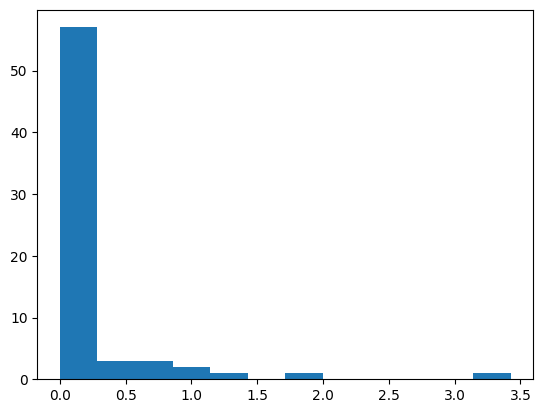


BETA SUMMARY:
beta initial:  [ 9.89  14.91  13.205 20.    10.455 12.503  0.    11.949 18.422 16.902]
beta final:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


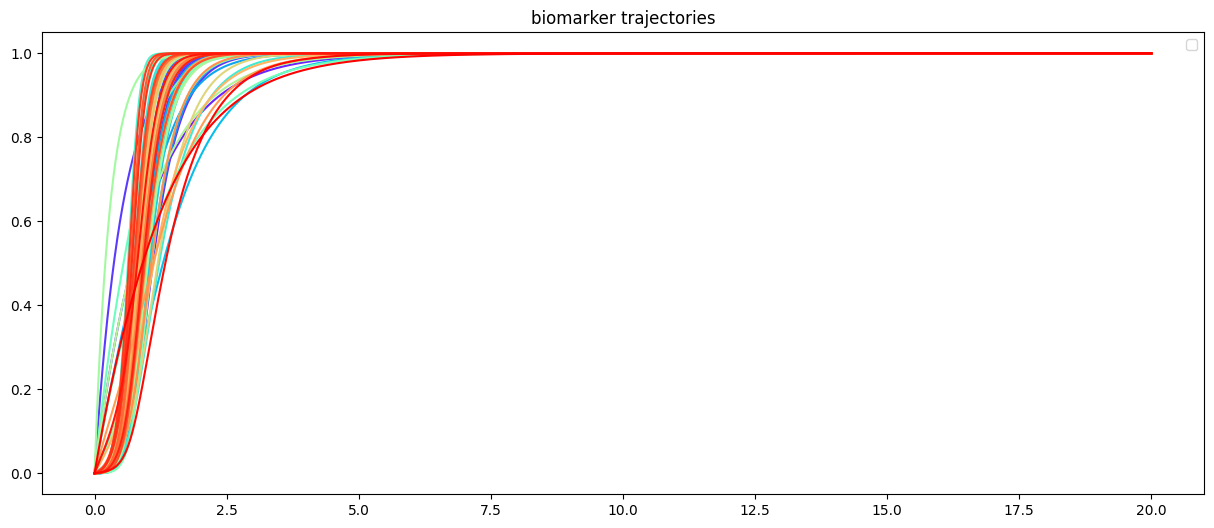

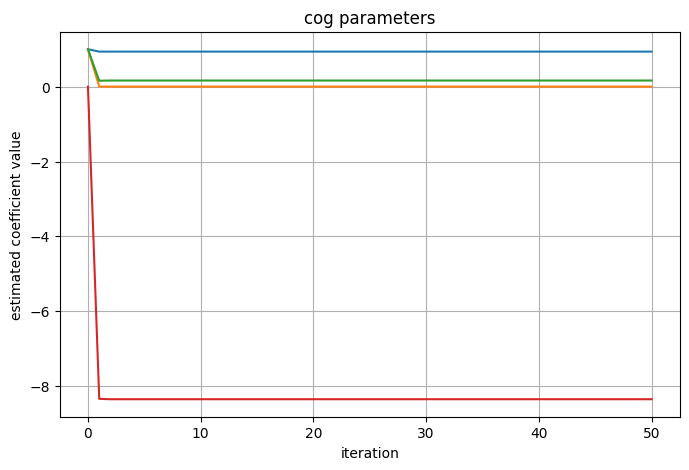

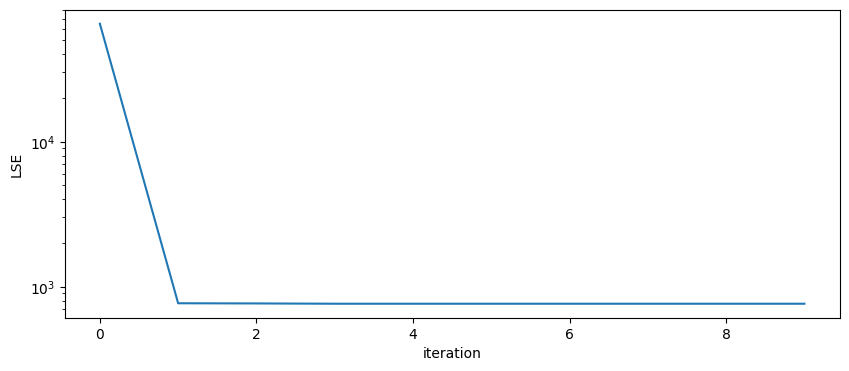

In [5]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:10])

In [6]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG"
em_model_1 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.1)
em_model_1.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  6%|▌         | 3/50 [01:26<19:09, 24.45s/it]

100%|██████████| 50/50 [10:04<00:00, 12.09s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.75696502 0.82660323 0.00722601 1.83715455 1.16391239 0.80716818
 0.44986651 0.26934583 0.01985015 0.38327388]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG.npz


EM(lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.1,
   rng=Generator(PCG64) at 0x7F08E84CACE0, step=0.001, t_max=20,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.757 0.827 0.007 1.837 1.164 0.807 0.45  0.269 0.02  0.383]
s:  [2.386 2.335 2.437 1.897 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  1.7962539292419215
n_zeros: 2


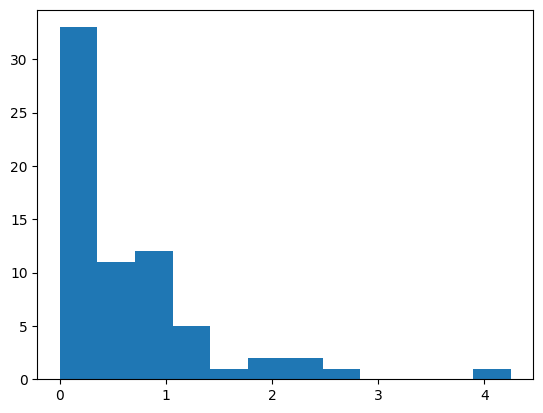


BETA SUMMARY:
beta initial:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]
beta final:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]


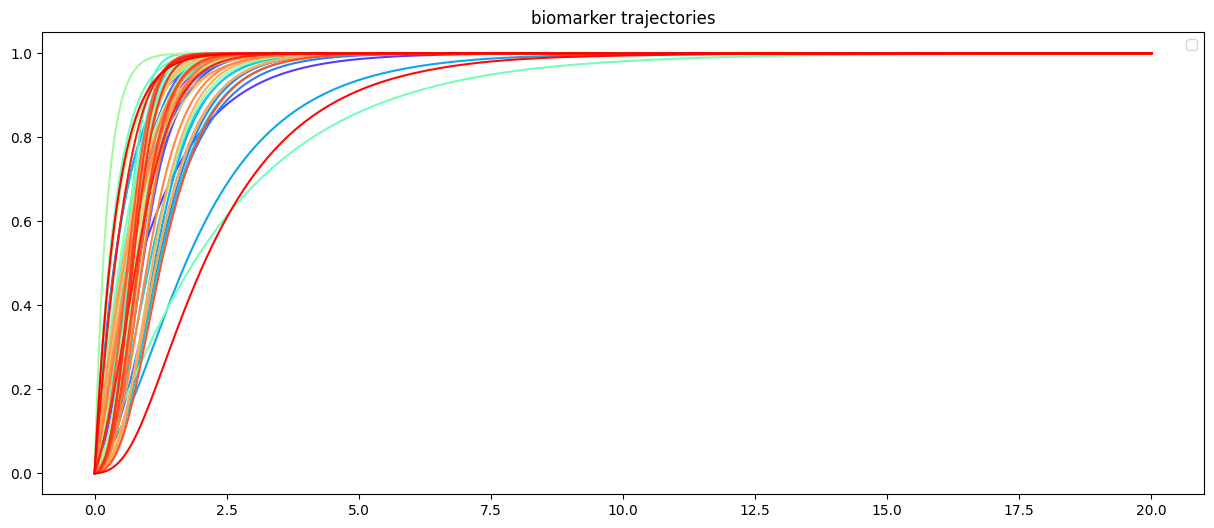

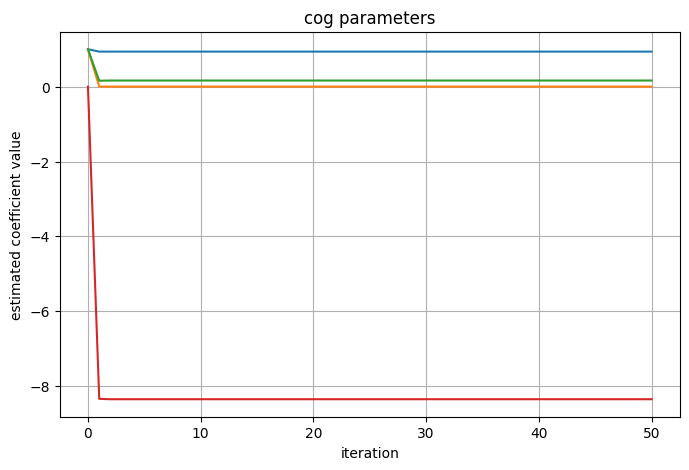

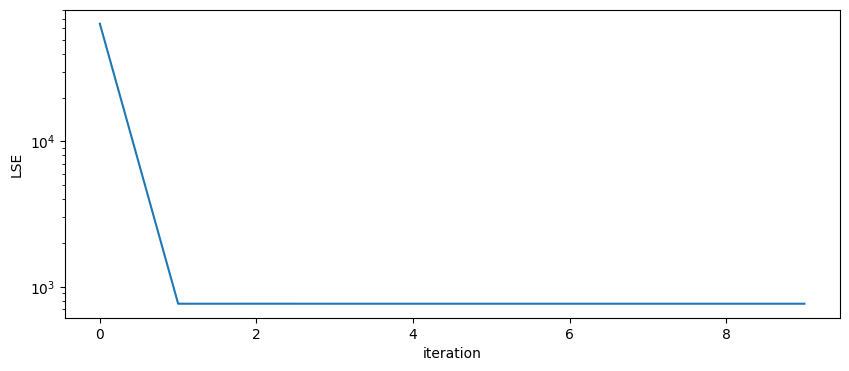

In [7]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_1.theta_history
beta_history = em_model_1.beta_history
lse_history = em_model_1.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:10])

In [8]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk1_betaREG"
em_model_2 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=1)
em_model_2.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [00:43<17:51, 22.33s/it]

  6%|▌         | 3/50 [09:02<3:07:57, 239.94s/it]

100%|██████████| 50/50 [17:33<00:00, 21.07s/it]  


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.1780428  0.55235261 0.         0.96842744 0.36652078 0.7179553
 0.08907043 0.1986136  0.21499994 0.15661684]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk1_betaREG.npz


EM(lambda_cog=0.0, lambda_f=0.1, lambda_scalar=1,
   rng=Generator(PCG64) at 0x7F08E1F02F80, step=0.001, t_max=20,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.178 0.552 0.    0.968 0.367 0.718 0.089 0.199 0.215 0.157]
s:  [2.386 2.335 2.437 1.897 3.137 2.624 2.324 2.639 2.205 2.156]
s_k:  0.8891622848533116
n_zeros: 5


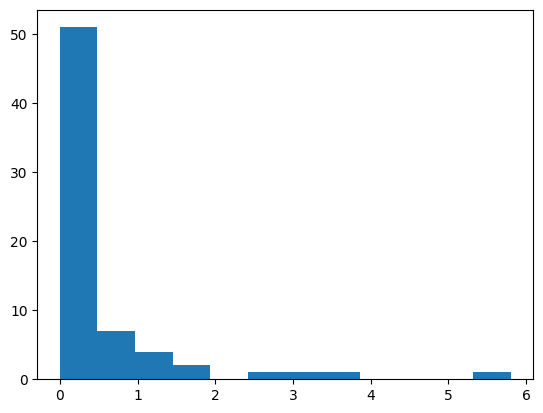


BETA SUMMARY:
beta initial:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]
beta final:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]


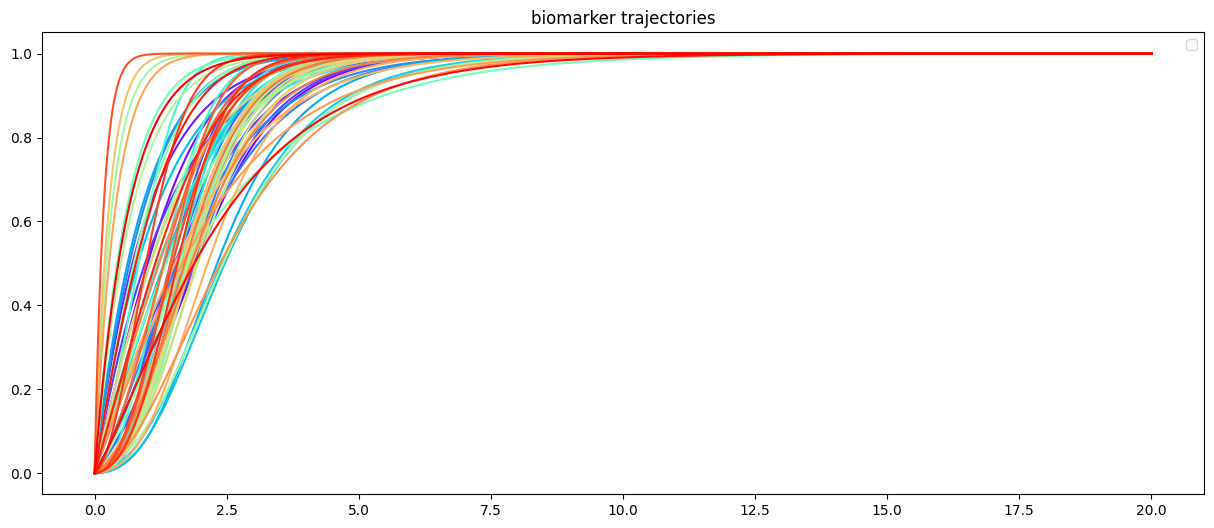

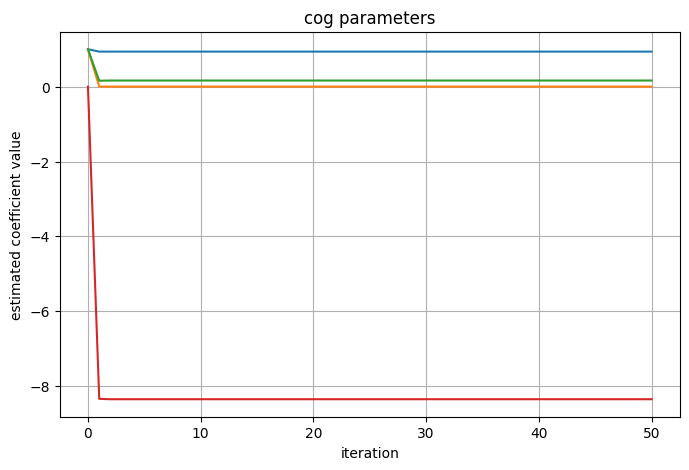

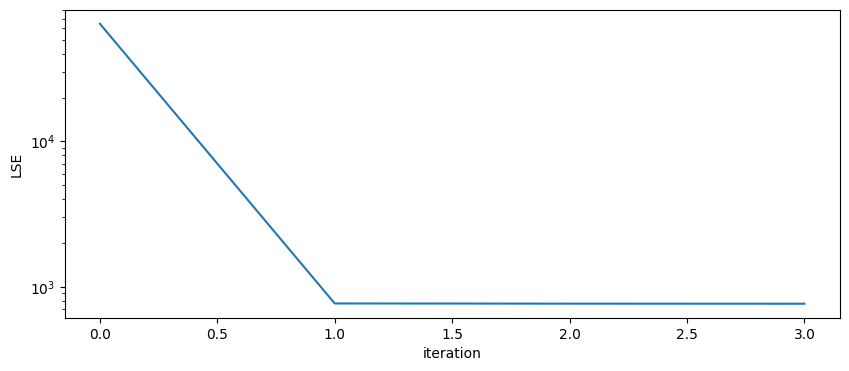

In [9]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_2.theta_history
beta_history = em_model_2.beta_history
lse_history = em_model_2.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])

In [10]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog01_f05_sk1_betaREG"
em_model_3 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.1, lambda_f=0.5, lambda_scalar=1)
em_model_3.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [14:05<5:20:20, 400.43s/it]

  6%|▌         | 3/50 [14:16<2:54:25, 222.66s/it]

100%|██████████| 50/50 [1:14:57<00:00, 89.95s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.00000000e+00 3.70168887e-02 0.00000000e+00 4.83535613e-01
 1.33440338e-01 5.56332878e-01 3.54976738e-07 2.91709036e-03
 1.25269210e-15 1.57420469e-06]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog01_f05_sk1_betaREG.npz


EM(lambda_cog=0.1, lambda_f=0.5, lambda_scalar=1,
   rng=Generator(PCG64) at 0x7F08E1DCAC00, step=0.001, t_max=20)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.    0.037 0.    0.484 0.133 0.556 0.    0.003 0.    0.   ]
s:  [2.386 2.335 2.437 1.898 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  1.4806753555390453
n_zeros: 15


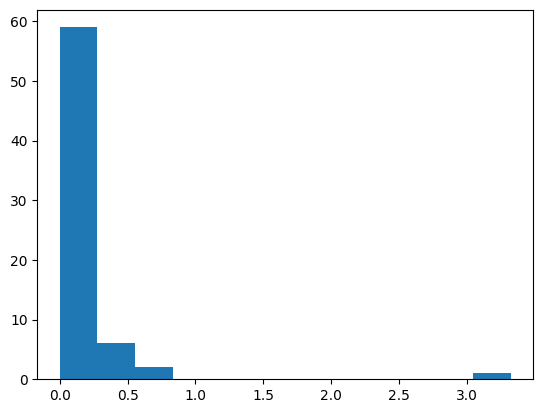


BETA SUMMARY:
beta initial:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]
beta final:  [ 9.89  20.    13.205 19.679 20.    20.    20.    20.    20.    20.   ]


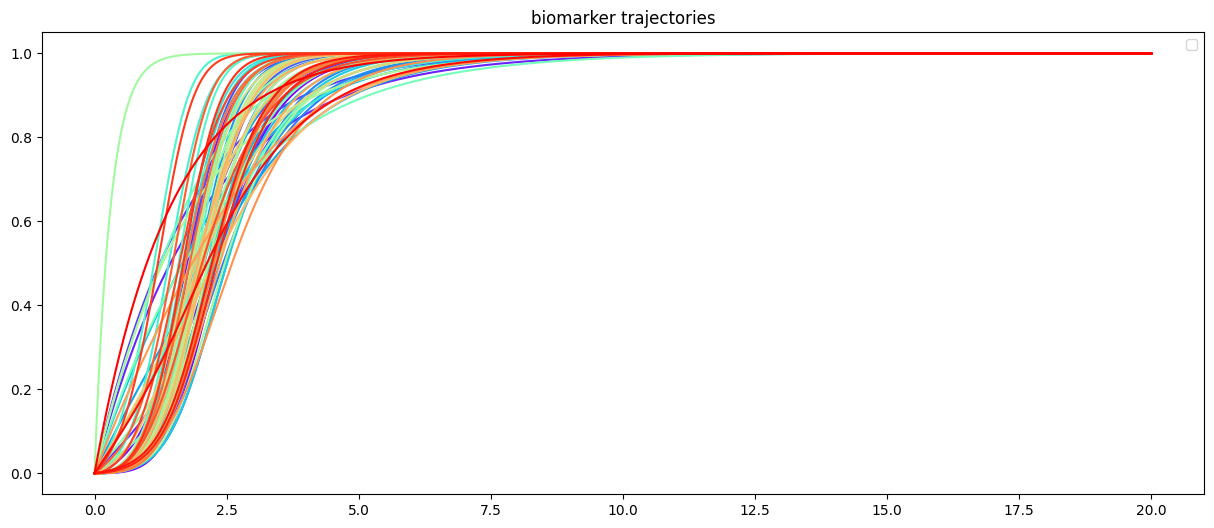

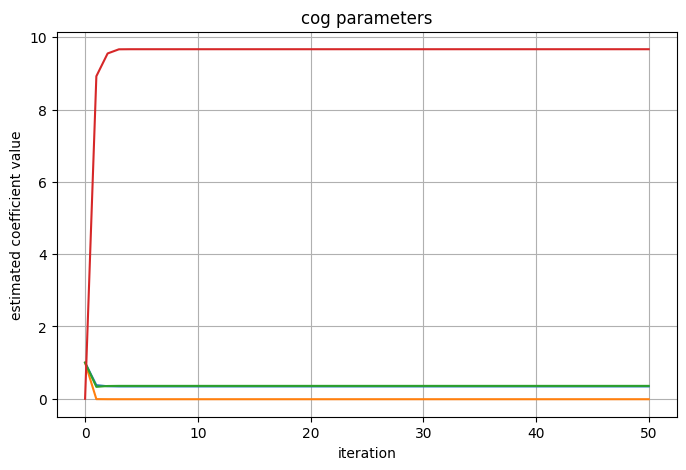

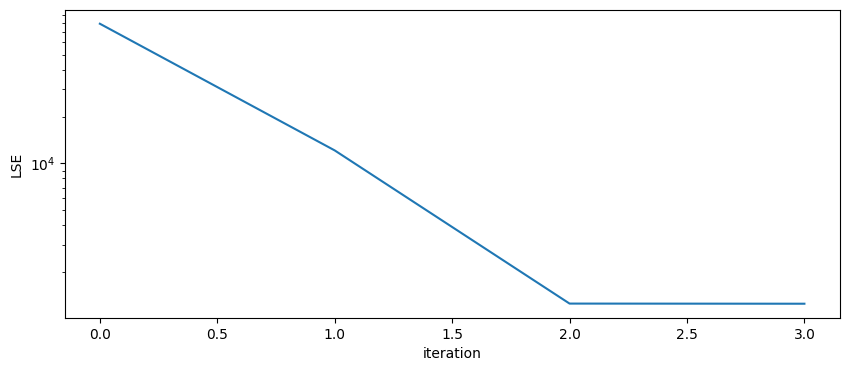

In [11]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_3.theta_history
beta_history = em_model_3.beta_history
lse_history = em_model_3.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_3.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])